In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import metrics

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection

In [4]:
from sklearn.dummy import DummyClassifier

## Data Load

In [5]:
data_path = "../data/uci_data.xls"

In [6]:
df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)

## Data cleaning

In [10]:
# I set all invalid values to 'other'
df.loc[~(df['EDUCATION'].isin([1, 2, 3, 4])), 'EDUCATION'] = 4
df.loc[~(df['MARRIAGE'].isin([1, 2, 3])), 'MARRIAGE'] = 3

## Data split

In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop(columns=("default payment next month"))
y_train = train[["default payment next month"]]
X_test = test.drop(columns=("default payment next month"))
y_test = test[["default payment next month"]]

In [12]:
train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000,2,2,2,24,0,0,0,0,0,...,73731,39643,39457,3503,5001,2092,1218,1445,878,0
252,30000,1,2,2,28,0,0,0,0,0,...,25255,22001,0,5006,1244,851,955,0,0,0
22942,180000,2,4,1,44,0,0,-1,-1,-1,...,0,6881,10340,0,850,0,6881,10340,182,0
619,60000,1,1,2,25,0,0,0,0,0,...,39639,39619,39140,2018,1900,2000,1500,1900,2000,0
17091,130000,2,2,2,25,0,0,0,0,0,...,117823,120854,123904,4100,4200,5000,5000,5000,10700,0


In [13]:
numeric_features = ["LIMIT_BAL", "AGE", 
                    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
                    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

categorical_features = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

## Naive classifier

In [14]:
dclf = DummyClassifier(strategy='most_frequent', random_state=42)
dclf = dclf.fit(X_train, y_train)
train_acc = metrics.accuracy_score(y_train, dclf.predict(X_train))
test_acc = metrics.accuracy_score(y_test, dclf.predict(X_test))
train_rec = metrics.recall_score(y_train, dclf.predict(X_train))
test_rec = metrics.recall_score(y_test, dclf.predict(X_test))
train_roc = metrics.roc_auc_score(y_train, dclf.predict(X_train))
test_roc = metrics.roc_auc_score(y_test, dclf.predict(X_test))
train_f1 = metrics.f1_score(y_train, dclf.predict(X_train))
test_f1 = metrics.f1_score(y_test, dclf.predict(X_test))
print(f"""
Train: 
    acc->{train_acc:.2}, rec->{train_rec:.2}
    roc->{train_roc:.2}
    f1->{train_f1:.2}
Test: 
    acc->{test_acc:.2}, rec->{test_rec:.2}
    roc->{test_roc:.2}
    f1->{test_f1:.2}""")


Train: 
    acc->0.78, rec->0.0
    roc->0.5
    f1->0.0
Test: 
    acc->0.78, rec->0.0
    roc->0.5
    f1->0.0


## Logistic Regression

In [43]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='liblinear',
                                                        class_weight='balanced', 
                                                        max_iter=5000))])

In [44]:
%%time
clf.fit(X_train, y_train.values.ravel());

CPU times: user 454 ms, sys: 82 µs, total: 454 ms
Wall time: 453 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION'

In [45]:
metrics.confusion_matrix(y_train, clf.predict(X_train))

array([[15594,  3083],
       [ 2232,  3091]])

C(0,0) True negatives
C(1,0) False negatives
C(1,1) True positives
C(0,1) False positives

In [46]:
metrics.confusion_matrix(y_test, clf.predict(X_test))

array([[3877,  810],
       [ 550,  763]])

In [76]:
train_pre = metrics.precision_score(y_train, clf.predict(X_train))
test_pre = metrics.precision_score(y_test, clf.predict(X_test))
train_acc = metrics.accuracy_score(y_train, clf.predict(X_train))
test_acc = metrics.accuracy_score(y_test, clf.predict(X_test))
train_rec = metrics.recall_score(y_train, clf.predict(X_train))
test_rec = metrics.recall_score(y_test, clf.predict(X_test))
train_roc = metrics.roc_auc_score(y_train, clf.predict(X_train))
test_roc = metrics.roc_auc_score(y_test, clf.predict(X_test))
train_f1 = metrics.f1_score(y_train, clf.predict(X_train))
test_f1 = metrics.f1_score(y_test, clf.predict(X_test))
print(f"""
Train: 
    acc->{train_acc:.2}, pre->{train_pre:.2}, rec->{train_rec:.2}, roc->{train_roc:.2}, f1->{train_f1:.2}
Test: 
    acc->{test_acc:.2}, pre->{test_pre:.2}, rec->{test_rec:.2}, roc->{test_roc:.2}, f1->{test_f1:.2}""")


Train: 
    acc->0.78, pre->0.5, rec->0.58, roc->0.71, f1->0.54
Test: 
    acc->0.77, pre->0.49, rec->0.58, roc->0.7, f1->0.53


In [75]:
metrics.precision_score(y_train, clf.predict(X_train))

0.5006478781988986

In [70]:
print(metrics.classification_report(y_train, clf.predict(X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.87      0.83      0.85     18677
     default       0.50      0.58      0.54      5323

    accuracy                           0.78     24000
   macro avg       0.69      0.71      0.70     24000
weighted avg       0.79      0.78      0.78     24000



CPU times: user 8min 48s, sys: 1.39 s, total: 8min 49s
Wall time: 8min 52s


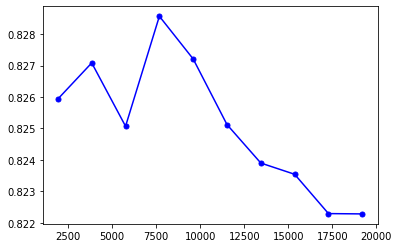

In [16]:
%%time
# Calculate training and test mean and std
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, 
                                                        X=X_train, 
                                                        y=y_train.values.ravel(), 
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1, 10),
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')

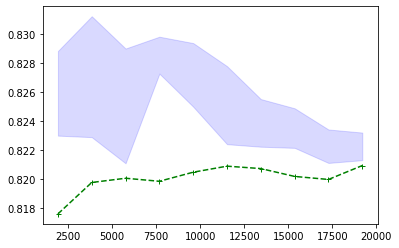

In [17]:
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')

## Hyperparameter Search

In [61]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [62]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.003, 0.006, 0.009, 0.01, 0.03, 0.03, 0.09,  0.1, 1, 10, 100]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)

In [63]:
%%time
model_lr = model_lr.fit(X_train, y_train.values.ravel())

CPU times: user 1min 16s, sys: 748 ms, total: 1min 16s
Wall time: 1min 16s


In [64]:
metrics.confusion_matrix(y_train, model_lr.predict(X_train))

array([[15590,  3087],
       [ 2237,  3086]])

In [65]:
metrics.confusion_matrix(y_test, model_lr.predict(X_test))

array([[3877,  810],
       [ 546,  767]])

In [66]:
train_acc = metrics.accuracy_score(y_train, model_lr.predict(X_train))
test_acc = metrics.accuracy_score(y_test, model_lr.predict(X_test))
train_rec = metrics.recall_score(y_train, model_lr.predict(X_train))
test_rec = metrics.recall_score(y_test, model_lr.predict(X_test))
train_roc = metrics.roc_auc_score(y_train, model_lr.predict(X_train))
test_roc = metrics.roc_auc_score(y_test, model_lr.predict(X_test))
train_f1 = metrics.f1_score(y_train, model_lr.predict(X_train))
test_f1 = metrics.f1_score(y_test, model_lr.predict(X_test))
print(f"""
Train: 
    acc->{train_acc:.2}, rec->{train_rec:.2}
    roc->{train_roc:.2}
    f1->{train_f1:.2}
Test: 
    acc->{test_acc:.2}, rec->{test_rec:.2}
    roc->{test_roc:.2}
    f1->{test_f1:.2}""")


Train: 
    acc->0.78, rec->0.58
    roc->0.71
    f1->0.54
Test: 
    acc->0.77, rec->0.58
    roc->0.71
    f1->0.53


In [67]:
model_lr.best_params_

{'classifier__C': 0.1, 'classifier__penalty': 'l2'}

In [28]:
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [6, 8, 9]
}

model_lr = model_selection.GridSearchCV(clf, param_grid=param_grid, cv=5)

model_lr = model_lr.fit(X_train, y_train.values.ravel())

In [29]:
metrics.confusion_matrix(y_train, model_lr.predict(X_train))

array([[17810,   867],
       [ 3401,  1922]])

In [30]:
metrics.confusion_matrix(y_test, model_lr.predict(X_test))

array([[4462,  225],
       [ 861,  452]])

In [31]:
metrics.accuracy_score(y_train, model_lr.predict(X_train)), metrics.recall_score(y_train, model_lr.predict(X_train))

(0.8221666666666667, 0.3610745820026301)

In [32]:
metrics.accuracy_score(y_test, model_lr.predict(X_test)), metrics.recall_score(y_test, model_lr.predict(X_test))

(0.819, 0.34424980959634427)

In [33]:
model_lr.best_params_

{'classifier__C': 8, 'classifier__penalty': 'l2'}